# Tutorial Overview

This tutorial is divided into five parts; they are:

1. Time Series Problem
2. Grid Search Framework
3. Grid Search Multilayer Perceptron
4. Grid Search Convolutional Neural Network
5. Grid Search Long Short-Term Memory Network

# Time Series Problem

In [5]:
%matplotlibt inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12,4), dpi=300)

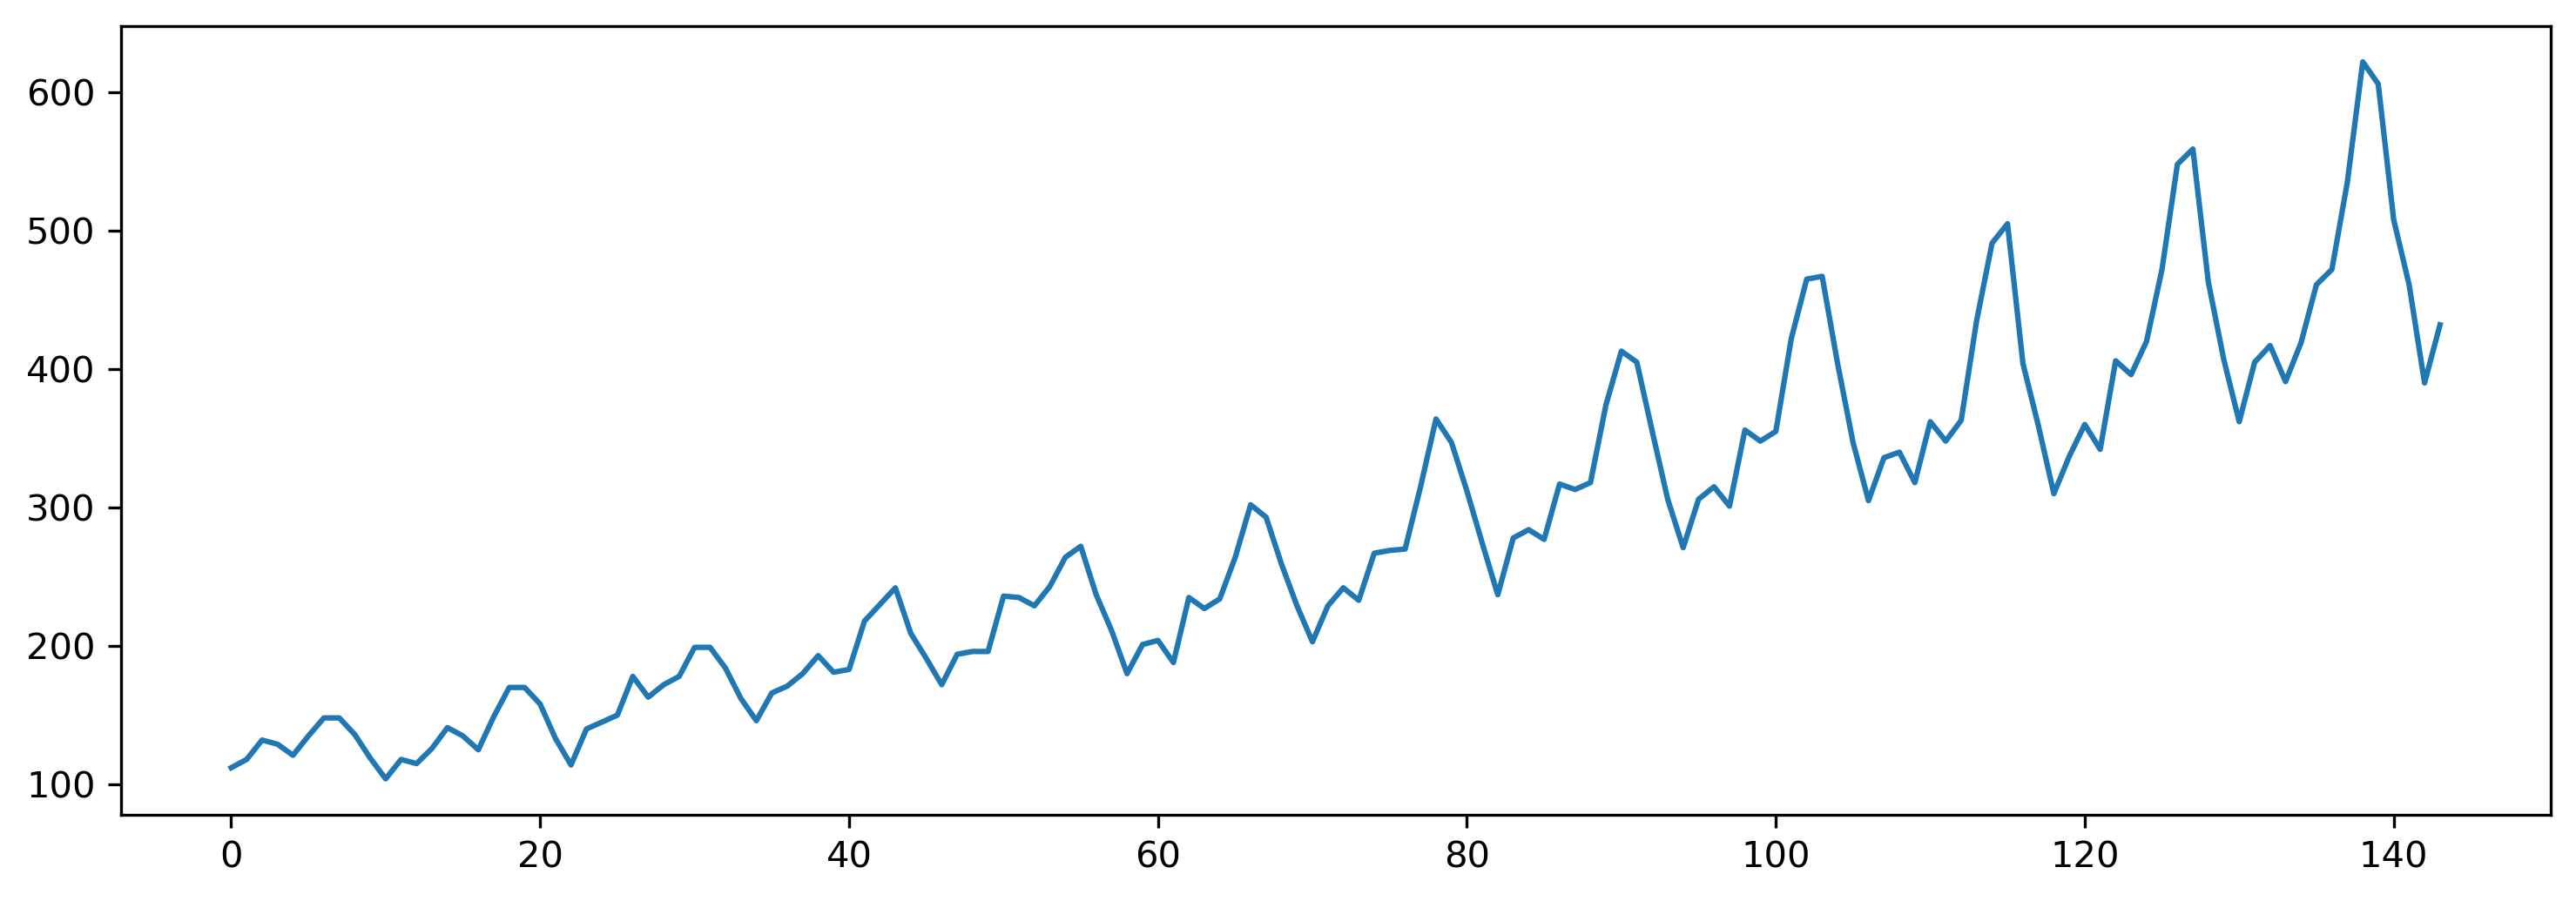

In [41]:
# load
series = pd.read_csv('airline-passengers.txt', header=0, index_col=0)

# plot
plt.plot(series.values)
plt.show()

# Grid Search Framework
In this section, we will develop a grid search test harness that can be used to evaluate a range of hyperparameters for different neural network models, such as MLPs, CNNs, and LSTMs.

This section is divided into the following parts:

- Train-Test Split
- Series as Supervised Learning
- Walk-Forward Validation
- Repeat Evaluation
- Summarize Performance
- Worked Example

## Train-Test Split

In [36]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [42]:
train, test = train_test_split(series, 12)
train.shape, test.shape

((132, 1), (12, 1))

In [55]:
# [x for x in train.values]

## Series as Supervised Learning

In [40]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        
    # put it all together
    agg = pd.concat(cols, axis=1)
    
    # drop rows with NaN values
    agg.dropna(inplace=True)
    
    return agg.values

In [24]:
series_to_supervised(series, n_in=3, n_out=3).shape

(139, 6)

## Walk-Forward Validation
Create a function that take
- **data** 
- **number of test**
- **model method** and 
- **its configs** as input  
and do these
- split train test
- create an empty list to store predictions
- create a list to store history, initialize using train set
- fit model using train and config
- in a for loop, 
    - predict using fitted model, history and config
    - store the prediction
    - update history by adding one observation from test set at a time
- compute model performance i.e. rmse
- **return** model's score

In [33]:
# root mean squared error or rmse
from sklearn.metrics import mean_squared_error as mse
def measure_rmse(actual, predicted):
    return np.sqrt(mse(actual, predicted))

In [26]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# Repeat Evaluate
We need this because Neural network models are stochastic.

In [25]:
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

# Grid Search

In [56]:
# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [58]:
# grid search persistence models for airline passengers
from math import sqrt
from numpy import mean
from pandas import read_csv
from sklearn.metrics import mean_squared_error

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
	return None

# forecast with a pre-fit model
def model_predict(model, history, offset):
	return history[-offset]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# define dataset
series = read_csv('airline-passengers.txt', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = [1, 6, 12, 24, 36]
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:10]:
	print(cfg, error)

 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
 > 53.152
> Model[1] 53.152
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
 > 126.735
> Model[6] 126.735
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
 > 50.708
> Model[12] 50.708
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
 > 97.110
> Model[24] 97.110
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
 > 110.274
> Model[36] 110.274
done
12 50.708316214732804
1 53.1515129919491
24 97.10990337413241
36 110.27352356753639
6 126.73495965991387


In [59]:
# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [12]
    n_nodes = [50, 100]
    n_epochs = [100]
    n_batch = [1, 150]
    n_diff = [0, 12]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [72]:
# difference dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

In [80]:
# grid search mlps for airline passengers
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    # transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    # separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with the fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    # shape input for model
    x_input = array(history[-n_input:]).reshape((1, n_input))
    # make forecast
    yhat = model.predict(x_input, verbose=0)
    # correct forecast if it was differenced
    return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [12]
    n_nodes = [50, 100]
    n_epochs = [100]
    n_batch = [1, 150]
    n_diff = [0, 12]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [81]:
%%time
# define dataset
series = read_csv('airline-passengers.txt', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

Total configs: 8
 > 19.748
 > 15.764
 > 33.577
 > 22.127
 > 17.059
 > 26.087
 > 17.439
 > 16.091
 > 17.514
 > 24.817
> Model[[12, 50, 100, 1, 0]] 21.022
 > 20.538
 > 18.873
 > 18.830
 > 22.602
 > 20.694
 > 20.053
 > 20.116
 > 22.289
 > 21.155
 > 22.675
> Model[[12, 50, 100, 1, 12]] 20.782
 > 106.969
 > 80.697
 > 35.183
 > 26.352
 > 56.428
 > 37.269
 > 61.365
 > 51.514
 > 76.310
 > 48.539
> Model[[12, 50, 100, 150, 0]] 58.063
 > 18.431
 > 20.736
 > 19.255
 > 21.911
 > 20.512
 > 19.623
 > 20.092
 > 19.816
 > 18.698
 > 19.805
> Model[[12, 50, 100, 150, 12]] 19.888
 > 31.905
 > 20.496
 > 19.809
 > 43.908
 > 30.138
 > 26.341
 > 20.512
 > 20.797
 > 24.716
 > 17.464
> Model[[12, 100, 100, 1, 0]] 25.609
 > 19.718
 > 20.280
 > 17.878
 > 21.582
 > 18.548
 > 19.424
 > 19.749
 > 17.715
 > 17.489
 > 19.054
> Model[[12, 100, 100, 1, 12]] 19.144
 > 68.526
 > 60.878
 > 41.085
 > 59.082
 > 62.341
 > 92.302
 > 59.049
 > 69.710
 > 56.714
 > 53.771
> Model[[12, 100, 100, 150, 0]] 62.346
 > 18.552
 > 19.63

In [79]:
%%time
from itertools import product
n_input = [12]
n_nodes = [50, 100]
n_epochs = [100]
n_batch = [1, 150]
n_diff = [0, 12]
list(product(n_input, n_nodes, n_epochs, n_batch, n_diff))

Wall time: 0 ns


[(12, 50, 100, 1, 0),
 (12, 50, 100, 1, 12),
 (12, 50, 100, 150, 0),
 (12, 50, 100, 150, 12),
 (12, 100, 100, 1, 0),
 (12, 100, 100, 1, 12),
 (12, 100, 100, 150, 0),
 (12, 100, 100, 150, 12)]

In [62]:
configs = model_configs()

Total configs: 8


In [67]:
configs

[[12, 50, 100, 1, 0],
 [12, 50, 100, 1, 12],
 [12, 50, 100, 150, 0],
 [12, 50, 100, 150, 12],
 [12, 100, 100, 1, 0],
 [12, 100, 100, 1, 12],
 [12, 100, 100, 150, 0],
 [12, 100, 100, 150, 12]]

In [82]:
# grid search lstm for airline passengers
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    # transform series into supervised format
    data = series_to_supervised(train, n_in=n_input)
    # separate inputs and outputs
    train_x, train_y = data[:, :-1], data[:, -1]
    # reshape input data into [samples, timesteps, features]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with the fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    # reshape sample into [samples, timesteps, features]
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [12]
    n_nodes = [100]
    n_epochs = [50]
    n_batch = [1, 150]
    n_diff = [12]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [83]:
%%time
# define dataset
series = read_csv('airline-passengers.txt', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
    print(cfg, error)

Total configs: 2
 > 22.343
 > 24.154
 > 26.751
 > 25.436
 > 23.017
 > 20.687
 > 20.557
 > 19.182
 > 20.134
 > 26.748
> Model[[12, 100, 50, 1, 12]] 22.901
 > 19.133
 > 21.177
 > 22.343
 > 20.084
 > 21.731
 > 27.475
 > 20.878
 > 20.306
 > 21.186
 > 23.892
> Model[[12, 100, 50, 150, 12]] 21.820
done
[12, 100, 50, 150, 12] 21.82047802317634
[12, 100, 50, 1, 12] 22.900949473825737
Wall time: 7min 48s
